# Train 2-layer Tybalt

**By Alexandra Lee**

**created December 2018**

Encode Pseudomonas gene expression data into low dimensional latent space using Tybalt with 2-hidden layers
 
Note: Need to use python 3 to support '*' syntax change

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from functions.my_classes import DataGenerator
from functions.helper_ae import sampling_maker, CustomVariationalLayer, WarmUpCallback

In [2]:
# To ensure reproducibility using Keras during development
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import numpy as np
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
randomState = 123
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import keras
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import metrics, optimizers
from keras.callbacks import Callback

## Initialize hyper parameters

1.  learning rate: 
2.  batch size: Total number of training examples present in a single batch.  Iterations is the number of batches needed to complete one epoch
3.  epochs: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE
4.  kappa: warmup
5.  original dim: dimensions of the raw data
6.  latent dim: dimensiosn of the latent space (fixed by the user)
    Note: intrinsic latent space dimension unknown
7.  epsilon std: 
8.  beta: Threshold value for ReLU?

In [3]:
# Initialize parameters
learning_rate = 0.00001
epochs = 100
kappa = 0.01

intermediate_dim = 200
latent_dim = 100
epsilon_std = 1.0
beta = K.variable(0)

chunk_size = 1000

subsample_dataset = "subsample_13K_validation_0.2"

# Get dimensions of datasets
train_dim_file =  os.path.join(os.path.dirname(os.getcwd()), "metadata", subsample_dataset, "train_tune_dim.pickle")
val_dim_file =  os.path.join(os.path.dirname(os.getcwd()), "metadata", subsample_dataset, "validation_tune_dim.pickle")

with open(train_dim_file, 'rb') as f:
    num_train_samples, num_genes = pickle.load(f)
with open(val_dim_file, 'rb') as f:
    num_val_samples, num_genes = pickle.load(f)

original_dim_model = num_genes
print(num_train_samples)#num_samples_train = 1319122
print(num_val_samples)#num_samples_val = 1319

10553
2638


In [4]:
# Load gene expression data using generator 
train_file =  "/home/alexandra/Documents/Data/LINCS_tuning/"+subsample_dataset+"/train_model_input.txt.xz"
validation_file = "/home/alexandra/Documents/Data/LINCS_tuning/"+subsample_dataset+"/validation_model_input.txt.xz"

training_generator = DataGenerator(train_file, chunk_size, num_train_samples)
validation_generator = DataGenerator(validation_file, chunk_size, num_val_samples)

In [5]:
# Output files
stat_file =  os.path.join(os.path.dirname(os.getcwd()), "stats", "tybalt_2layer_{}latent_stats.tsv".format(latent_dim))
hist_plot_file = os.path.join(os.path.dirname(os.getcwd()), "stats", "tybalt_2layer_{}latent_hist.png".format(latent_dim))

encoded_file = os.path.join(os.path.dirname(os.getcwd()), "encoded", "train_input_2layer_{}latent_encoded.txt".format(latent_dim))

model_encoder_file = os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_2layer_{}latent_encoder_model.h5".format(latent_dim))
weights_encoder_file = os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_2layer_{}latent_encoder_weights.h5".format(latent_dim))
model_decoder_file = os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_2layer_{}latent_decoder_model.h5".format(latent_dim))
weights_decoder_file = os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_2layer_{}latent_decoder_weights.h5".format(latent_dim))

In [6]:
# Architecture of VAE
dim_file =  os.path.join(os.path.dirname(os.getcwd()), "metadata", subsample_dataset, "validation_tune_dim.pickle")

with open(dim_file, 'rb') as f:
    num_samples, num_genes = pickle.load(f)

original_dim = num_genes
rnaseq_input = Input(shape=(original_dim, ))

# Encoder

# Input layer is compressed into a mean and log variance vector of size
# `latent_dim`. Each layer is initialized with glorot uniform weights and each
# step (dense connections, batch norm,and relu activation) are funneled
# separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

# "z_mean_dense_linear" is the encoded representation of the input
#    Take as input arrays of shape (*, original dim) and output arrays of shape (*, latent dim)
#    Combine input from previous layer using linear summ
# Normalize the activations (combined weighted nodes of the previous layer)
#   Transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
# Apply ReLU activation function to combine weighted nodes from previous layer
#   relu = threshold cutoff (cutoff value will be learned)
#   ReLU function filters noise

# X is encoded using Q(z|X) to yield mu(X), sigma(X) that describes latent space distribution
hidden_dense_linear = Dense(intermediate_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
hidden_dense_batchnorm = BatchNormalization()(hidden_dense_linear)
hidden_encoded = Activation('relu')(hidden_dense_batchnorm)

# Note:
# Normalize and relu filter at each layer adds non-linear component (relu is non-linear function)
# If architecture is layer-layer-normalization-relu then the computation is still linear
# Add additional layers in triplicate
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# Customized layer
# Returns the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a
# latent_dim` output
#
# sampling():
# randomly sample similar points z from the latent normal distribution that is assumed to generate the data,
# via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor
# z ~ Q(z|X)
# Note: there is a trick to reparameterize to standard normal distribution so that the space is differentiable and 
# therefore gradient descent can be used
#
# Returns the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a
# latent_dim` output
#z = Lambda(sampling,
#           output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])
z = Lambda(sampling_maker(epsilon_std),
               output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# Decoder

# The decoding layer is much simpler with a single layer glorot uniform
# initialized and sigmoid activation
# Reconstruct P(X|z)
decoder_model = Sequential()
decoder_model.add(Dense(intermediate_dim, activation='relu', input_dim=latent_dim))
decoder_model.add(Dense(original_dim, activation='sigmoid'))
rnaseq_reconstruct = decoder_model(z)


# Connections
# fully-connected network
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer(original_dim, z_log_var_encoded, z_mean_encoded, beta)([
        rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/ipykernel/__main__.py:81: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [7]:
%%time
# Training
# hist: record of the training loss at each epoch
hist = vae.fit_generator(generator=training_generator,
                         validation_data=validation_generator,
                         shuffle=True,
                         epochs=epochs,
                         callbacks=[WarmUpCallback(beta, kappa)])

Epoch 1/100
10/10 [==============================] - 6s 637ms/step - loss: 708.0984 - val_loss: 706.5732
Epoch 2/100
10/10 [==============================] - 6s 584ms/step - loss: 706.6116 - val_loss: 705.1453
Epoch 3/100
10/10 [==============================] - 6s 588ms/step - loss: 705.2828 - val_loss: 703.3218
Epoch 4/100
10/10 [==============================] - 6s 590ms/step - loss: 703.9293 - val_loss: 702.1812
Epoch 5/100
10/10 [==============================] - 6s 585ms/step - loss: 702.6951 - val_loss: 701.0727
Epoch 6/100
10/10 [==============================] - 6s 590ms/step - loss: 701.5259 - val_loss: 699.5498
Epoch 7/100
10/10 [==============================] - 6s 603ms/step - loss: 700.4891 - val_loss: 698.8592
Epoch 8/100
10/10 [==============================] - 6s 591ms/step - loss: 699.1730 - val_loss: 697.8353
Epoch 9/100
10/10 [==============================] - 6s 611ms/step - loss: 698.0272 - val_loss: 696.8485
Epoch 10/100
10/10 [==============================] - 6

In [8]:
# Trained model
encoder = Model(rnaseq_input, z_mean_encoded)

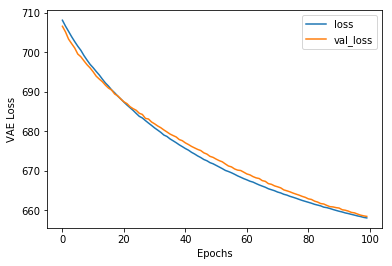

In [9]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
#loss_df = pd.DataFrame(hist.history['loss'])
#ax = loss_df.plot()
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

In [11]:
# Output

# Save training performance
history_df = pd.DataFrame(hist.history)
history_df = history_df.assign(learning_rate=learning_rate)
#history_df = history_df.assign(batch_size=batch_size)
history_df = history_df.assign(epochs=epochs)
history_df = history_df.assign(kappa=kappa)
history_df.to_csv(stat_file, sep='\t')

# Save models
# (source) https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# Save encoder model
encoder.save(model_encoder_file)
    
# serialize weights to HDF5
encoder.save_weights(weights_encoder_file)

# Save decoder model
# (source) https://github.com/greenelab/tybalt/blob/master/scripts/nbconverted/tybalt_vae.py
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_model(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

decoder.save(model_decoder_file)
    
# serialize weights to HDF5
decoder.save_weights(weights_decoder_file)